In [1]:
import torch
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import joblib
import sys
import numpy as np
import json
import time
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, precision_score, roc_auc_score,
    top_k_accuracy_score
)


CLIP_FEATURES_DIR = "clip_features"
VAL = CLIP_FEATURES_DIR + "/val_features.pt"
SCALER = "scaler_model.joblib"
PCA = "pca_model.joblib"
LIME = "top_k_lime_indices.joblib"

In [2]:
def load_features(file_path):
    data = torch.load(file_path)
    return data["image_features"], data["text_features"], data["filenames"], data["labels"]


# Load train and validation features
val_img_features, val_txt_features, _, val_labels = load_features(VAL)

In [3]:
# Combine image and text features for training
X_val = torch.cat((val_img_features, val_txt_features), dim=1)

# Flatten features into a 2D matrix (samples x features)
X_val = X_val.view(X_val.size(0), -1).numpy()

# Print the shape of the features
print(f"X_val shape: {X_val.shape}")

# Convert labels to NumPy arrays
y_val = val_labels.numpy()  

# Load scaler and PCA models
scaler = joblib.load(SCALER)
pca = joblib.load(PCA)
lime = joblib.load(LIME)

# Scale and transform the features
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)
X_val_lime = X_val_scaled[:, lime]

X_val shape: (1985, 1024)


In [4]:
from classifiers import (
    SVMClassifier, RBFClassifier, RandomForestClassifier, NaiveBayesClassifier, 
    LogisticRegressionClassifier, LDAClassifier, KNNClassifier, DecisionTreeClassifier,
    AdaBoostClassifier, GBMClassifier, XGBoostClassifier
)

from ensembler import EnsemblerClassifier

# Instantiate classifiers
classifiers = [
    SVMClassifier(), RBFClassifier(), RandomForestClassifier(), NaiveBayesClassifier(),
    LogisticRegressionClassifier(), LDAClassifier(), KNNClassifier(),
    DecisionTreeClassifier(), AdaBoostClassifier(), GBMClassifier(),
    XGBoostClassifier()
]

# Define weights
weights = [0.2, 0.0, 0.1, 0.05, 0.1, 0.05, 0.05, 0.1, 0.1, 0.2, 0.05]

# Load models
for clf in classifiers:
    clf.load(model_dir="models_pca_cal_sig")

# Build ensemble input as (classifier, weight) pairs
classifier_weight_pairs = list(zip(classifiers, weights))

# Initialize ensemble
ensemble = EnsemblerClassifier(classifier_weight_pairs)





Loaded model from: models_pca_cal_sig/SVM.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_cal_sig/RBF.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_cal_sig/RandomForest.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_cal_sig/NaiveBayes.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_cal_sig/LogisticRegression.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_cal_sig/LDA.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_cal_sig/KNN.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_cal_sig/DecisionTree.joblib
Loaded label encoder from: models_pca_cal_sig/label_encoder.joblib
Loaded model from: models_pca_ca

In [ ]:

classifier = classifiers[0]  
#print("Classes from classifier:", classifier.model.classes_)

  
y_pred = classifier.classify(X_val_pca)
y_prob = classifier.classify_proba(X_val_pca)
y_pred2 = np.argmax(y_prob, axis=1) + 1

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
accuracy2 = accuracy_score(y_val, y_pred2)
recall = recall_score(y_val, y_pred, average='macro')
recall2 = recall_score(y_val, y_pred2, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')
f1_2 = f1_score(y_val, y_pred2, average='macro')

#print("Shape of y_prob:", y_prob.shape)
#print("Unique labels in y_val:", np.unique(y_val))


print("Accuracy", accuracy)
print("Accuracy2", accuracy2)
print("Recall", recall)
print("Recall2", recall2)
print("F1 Score", f1)
print("F1 Score2", f1_2)
 


Classes from classifier: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76]


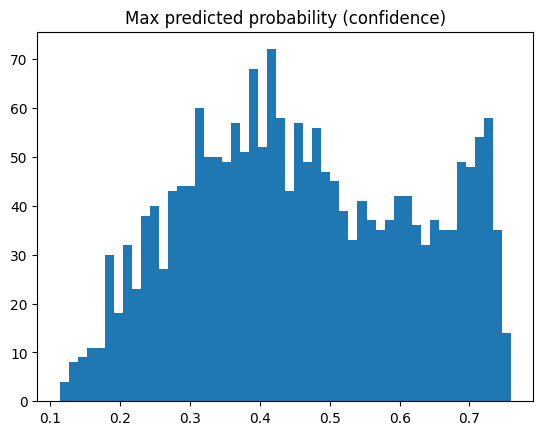

In [6]:
proba = ensemble.classify_proba(X_val_pca)
confidences = np.max(proba, axis=1)
import matplotlib.pyplot as plt
plt.hist(confidences, bins=50)
plt.title("Max predicted probability (confidence)")
plt.show()

In [ ]:
y_pred = ensemble.classify(X_val_pca)
y_proba = ensemble.classify_proba(X_val_pca)


#print accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")


# Print other metrics
recall = recall_score(y_val, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_val, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")
precision = precision_score(y_val, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")
roc_auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted', labels=np.arange(1, 91))
print(f"ROC AUC: {roc_auc:.4f}")
# Calculate top-k accuracy
top_k_accuracy = top_k_accuracy_score(y_val, y_proba, k=5, labels=np.arange(1, 91))
print(f"Top-k Accuracy: {top_k_accuracy:.4f}")


Accuracy: 0.0045
Max Accuracy: 0.0045
Recall: 0.0045
Recall: 0.0045
F1 Score: 0.0049
Precision: 0.0065
ROC AUC: 0.9434
Top-k Accuracy: 0.9068


/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/thesis/venv/li